# Time Series Forecasting for SOTA OG

**Objective** - 

The gas well has sensors that feedback data at every step of the pipeline. The usual pipeline steps are reservoir pressure, tubing pressure, casing pressure, choke point, position, line pressure, and combine point. The data captured at each step of the pipeline is utilised for a real-time dashboard and for making future predictions based on historical data.

## Dataset and EDA

**Data Understanding -**

As stated above, there are variables that are related to the state of gas flow at that timestamp,like gas metre temperature, gas metre static pressure, and gas metre differential pressure, and there are other variables associated with data points at the pipeline level.


**Descriptive Understanding**

One month of data with variables (bottom hole pressure, tubing pressure, casing pressure, line pressure, gas meter pressure, temperature, etc.) is being shared, where each data point is spaced over a 10-minute interval. 

We will filter the data when line pressures of both gas wells are within
the range of 530–630 psi.

**Usual Imports**

In [446]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from datetime import datetime

In [447]:
def parse(x):
    date_conv = datetime.fromtimestamp(x/1000.0)
    return date_conv.strftime('%d-%m-%Y-%H-%M-%S')

gas_well_df = pd.read_csv('../dat/input_gas_well.csv')
gas_well_df['date'] = gas_well_df['Timestamp'].apply(lambda x : parse(x))

gas_well_df.drop('Timestamp', axis=1, inplace=True)
gas_well_df['date'] = pd.to_datetime(gas_well_df['date'], format='%d-%m-%Y-%H-%M-%S')
gas_well_df.sort_values('date', ascending=True, inplace=True)

gas_well_df.head(3)

,Gas Meter Temperature_x,Line Pressure_x,Position_x,Tubing Pressure_x,Reservoir Pressure_x,Gas Meter Flow Rate_x,Gas Meter Temperature_y,Line Pressure_y,Position_y,Tubing Pressure_y,Reservoir Pressure_y,Gas Meter Flow Rate_y,Junction pressure,date
0,98.02,527.06,54.16,733.78,1233.97736,16260.90,90.40,521.95,46.23,835.08,1719.674289,15223.68,494.238609,2023-03-26 00:07:00
1,98.16,528.75,54.02,732.94,1233.97736,16132.45,90.47,522.19,45.44,834.61,1719.674289,15195.81,495.408491,2023-03-26 00:17:00
2,98.10,527.91,54.16,730.69,1233.97736,16203.42,90.32,523.24,45.68,836.02,1719.674289,15296.72,495.222547,2023-03-26 00:27:00


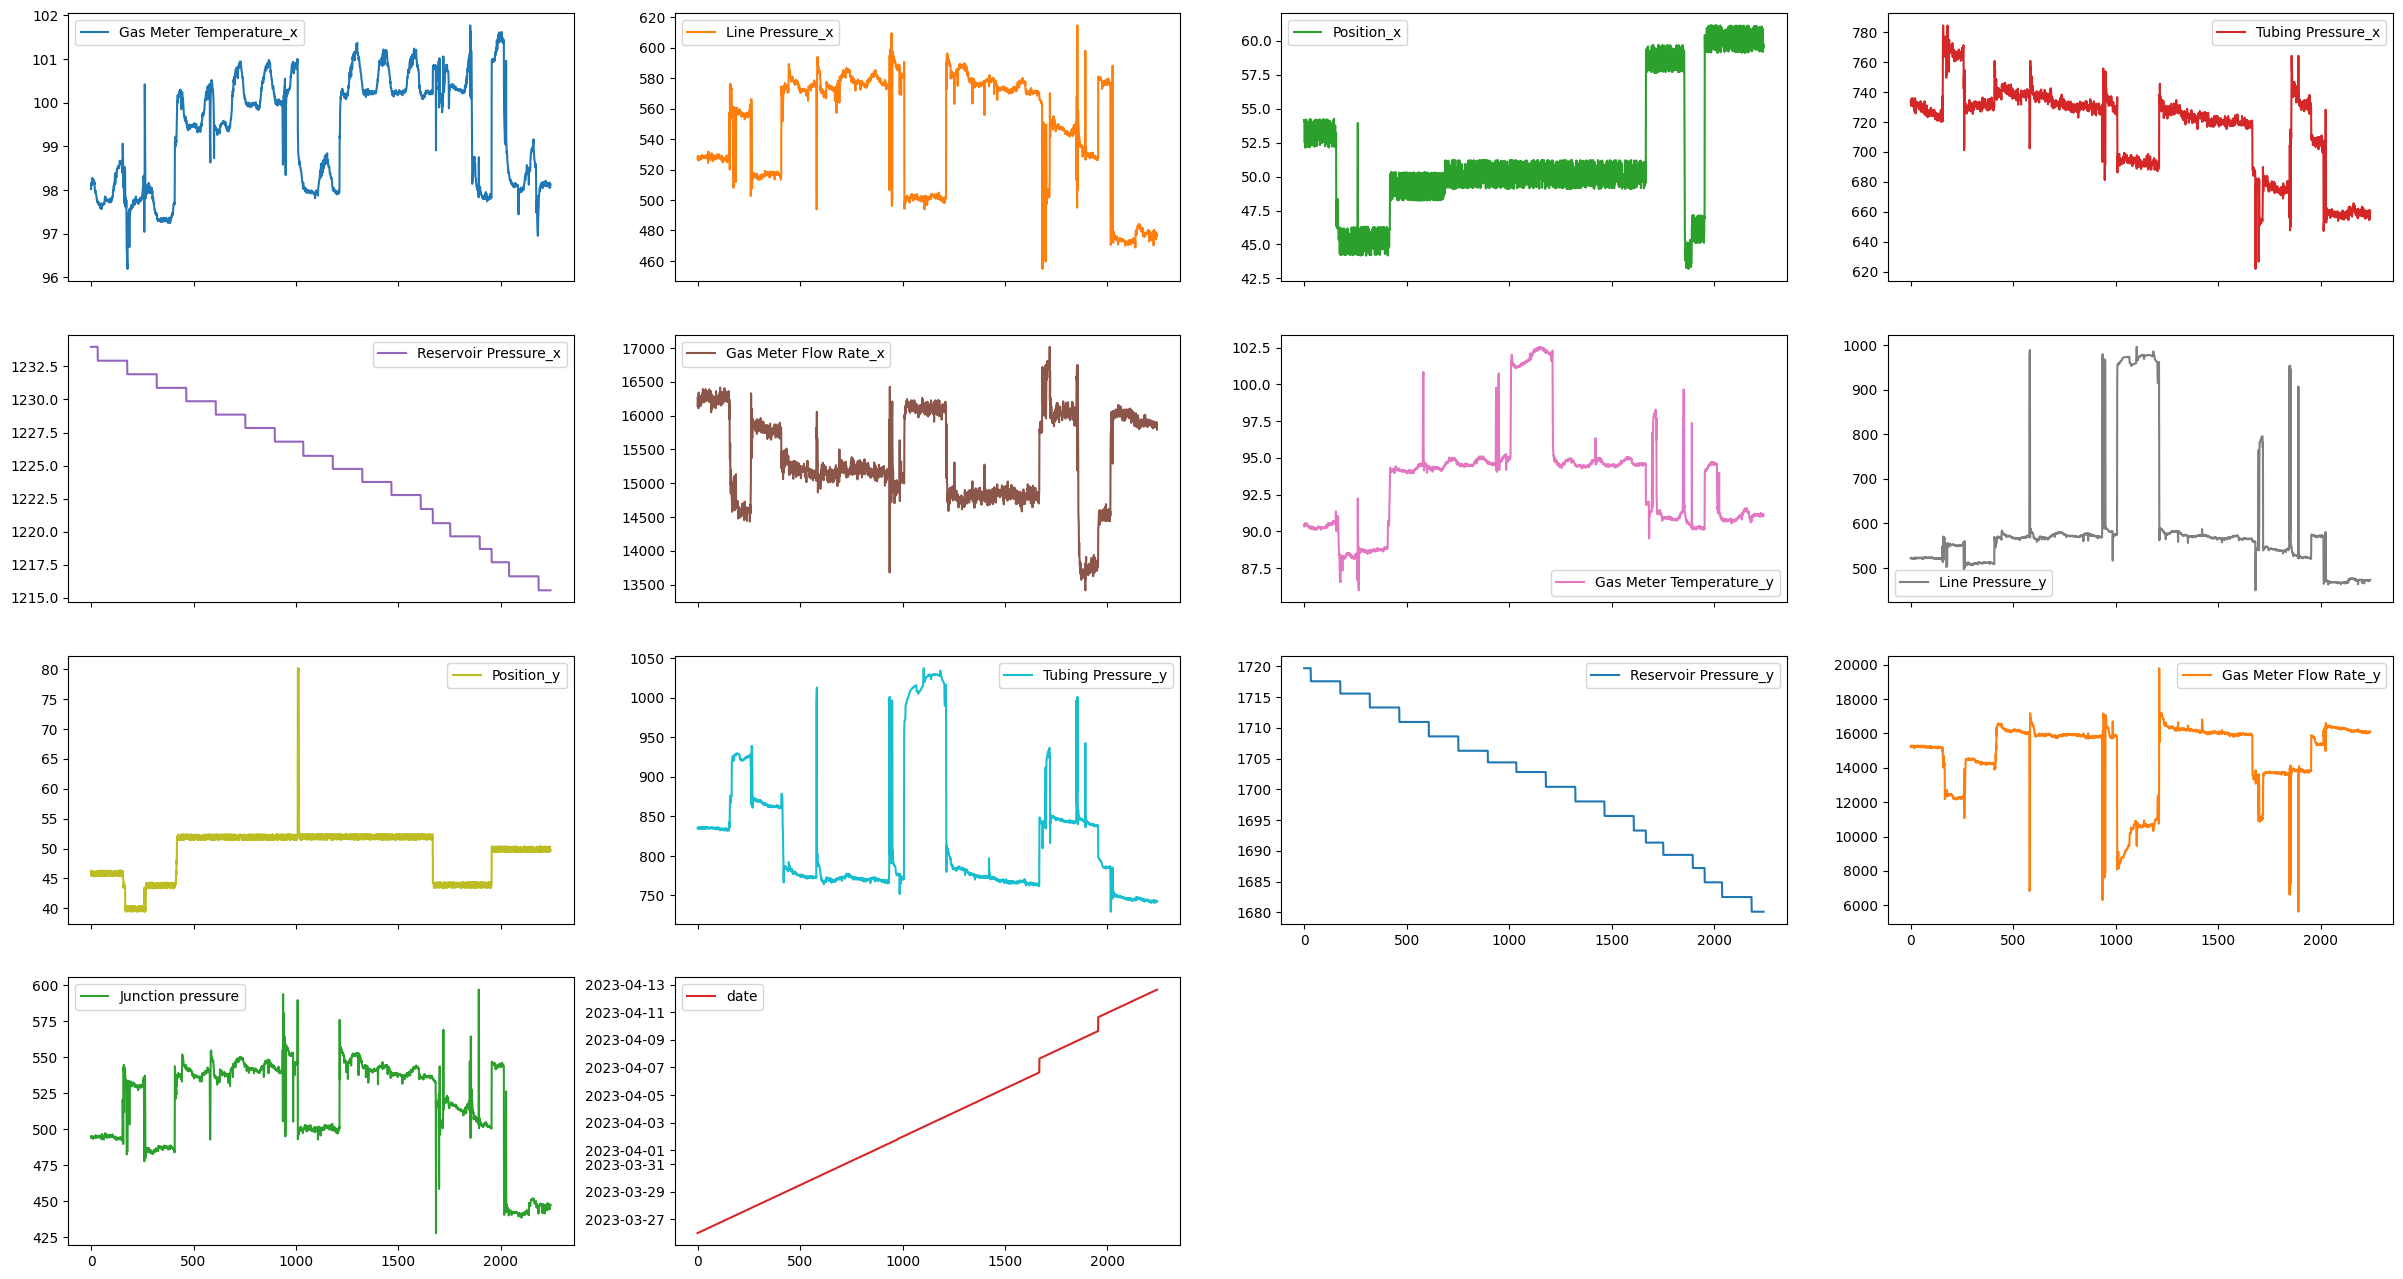

In [448]:
# Facet plots of the jobs dataset
gas_well_df.plot(subplots=True, layout=(4, 4),
          figsize=(30, 16),
          sharex=True,
          sharey=False)
plt.show()

Text(0.5, 1.0, 'Box plot of Gas Meter Flow Rate')

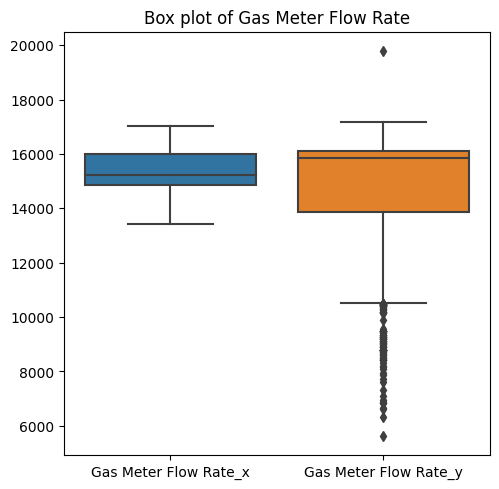

In [449]:
#Let us draw a box plot to visualize the central tendency and dispersion of gas flow rate
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(gas_well_df[['Gas Meter Flow Rate_x','Gas Meter Flow Rate_y']])
g.set_title('Box plot of Gas Meter Flow Rate')

Text(0, 0.5, 'Gas Flow Rate')

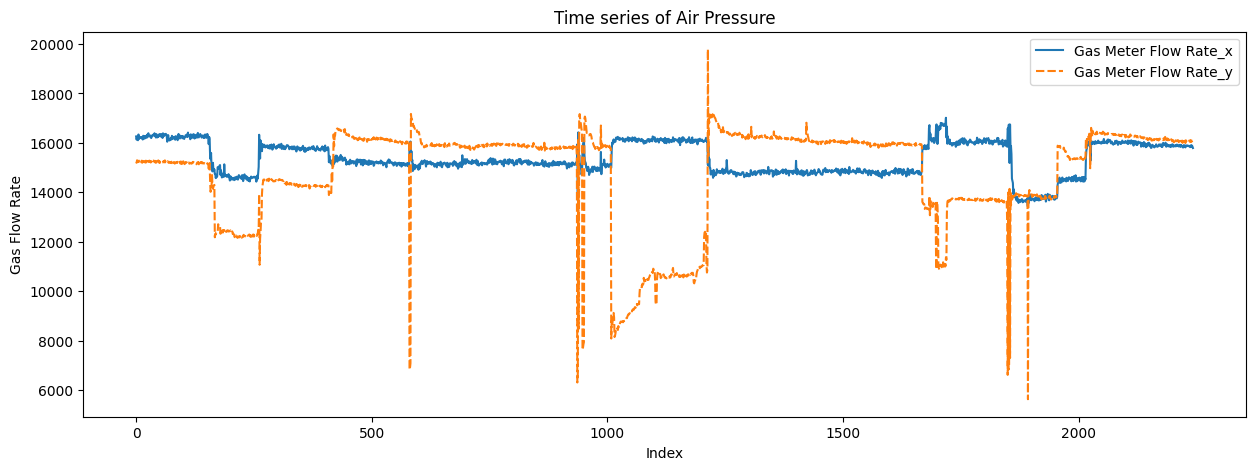

In [450]:
plt.figure(figsize=(15, 5))
g = sns.lineplot(gas_well_df[['Gas Meter Flow Rate_x', 'Gas Meter Flow Rate_y']])
g.set_title('Time series of Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Gas Flow Rate')

In [451]:
col_x, col_y, = list(), list()

for col in gas_well_df.columns:
   if '_x' in col:
     col_x.append(col)
   elif '_y' in col:
      col_y.append(col)

other_columns = ['Junction pressure', 'date', 'year','month', 'day', 'hour', 'minute']

# Separate well x and y columns
gas_well_df_x = gas_well_df.drop(columns=col_y, axis=1)
gas_well_df_y = gas_well_df.drop(columns=col_x, axis=1)

# Reorder columns
gas_well_df_x = gas_well_df_x.iloc[:, [7, 5, 0, 1, 2, 3, 4, 6]]
gas_well_df_y = gas_well_df_y.iloc[:, [7, 5, 0, 1, 2, 3, 4, 6]]

#
gas_well_df_x = gas_well_df_x.set_index('date')
gas_well_df_y = gas_well_df_y.set_index('date')

#
gas_well_df_x.head()

,Gas Meter Flow Rate_x,Gas Meter Temperature_x,Line Pressure_x,Position_x,Tubing Pressure_x,Reservoir Pressure_x,Junction pressure
date,,,,,,,
2023-03-26 00:07:00,16260.90,98.02,527.06,54.16,733.78,1233.97736,494.238609
2023-03-26 00:17:00,16132.45,98.16,528.75,54.02,732.94,1233.97736,495.408491
2023-03-26 00:27:00,16203.42,98.10,527.91,54.16,730.69,1233.97736,495.222547
2023-03-26 00:37:00,16142.20,98.11,526.50,52.49,732.94,1233.97736,494.232851
2023-03-26 00:47:00,16107.08,98.18,525.94,53.80,731.81,1233.97736,494.256190


### 3. Multivariate LSTM Forecast Model

#### LSTM Data preparation

- This involves framing the dataset as a supervised learning problem and normalizing the input variables.

- We will frame the supervised learning problem as predicting the Gas Meter FLow Rate_x at the current hour (t) given the poas Meter FLow Rate_x measurement and othe conditions at the prior time step.

**Normalized and Transformation**

In [452]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

df_x_values = gas_well_df_x.values
df_x_scaled = scaler.fit_transform(df_x_values)

In [510]:
df_x_scaled.shape

(2243, 7)

In [453]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('vars%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [454]:

#frame as supervised learning
df_x_supervised = series_to_supervised(df_x_scaled, 1, 1)
df_x_supervised.head()

,vars1(t-1),vars2(t-1),vars3(t-1),vars4(t-1),vars5(t-1),vars6(t-1),vars7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.790278,0.327957,0.452457,0.611266,0.688565,1.0,0.392223,0.754621,0.353047,0.463036,0.603458,0.683398,1.0,0.399146
2,0.754621,0.353047,0.463036,0.603458,0.683398,1.0,0.399146,0.774322,0.342294,0.457778,0.611266,0.669558,1.0,0.398046
3,0.774322,0.342294,0.457778,0.611266,0.669558,1.0,0.398046,0.757328,0.344086,0.448951,0.518126,0.683398,1.0,0.392189
4,0.757328,0.344086,0.448951,0.518126,0.683398,1.0,0.392189,0.747579,0.356631,0.445446,0.591188,0.676447,1.0,0.392327
5,0.747579,0.356631,0.445446,0.591188,0.676447,1.0,0.392327,0.812164,0.372760,0.463036,0.528165,0.700683,1.0,0.397797


In [455]:
# drop columns we don't want to predict
df_x_supervised.drop(columns= ['var2(t)', 'var3(t)', 'var4(t)',
       'var5(t)', 'var6(t)', 'var7(t)'], axis=1, inplace=True)

In [456]:
df_x_supervised.columns

Index(['vars1(t-1)', 'vars2(t-1)', 'vars3(t-1)', 'vars4(t-1)', 'vars5(t-1)',
       'vars6(t-1)', 'vars7(t-1)', 'var1(t)'],
      dtype='object')

This data preparation is simple and there is more we could explore. Some ideas you could look at include:

- Making all series stationary with differencing and seasonal adjustment.
- Providing last immediate 10 minute interval of input time steps.

This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

In [457]:
df_x_supervised.values

array([[0.79027812, 0.32795699, 0.45245696, ..., 1.        , 0.39222302,
        0.75462124],
       [0.75462124, 0.35304659, 0.46303599, ..., 1.        , 0.39914627,
        0.77432205],
       [0.77432205, 0.34229391, 0.45777778, ..., 1.        , 0.39804587,
        0.75732777],
       ...,
       [0.67486308, 0.34229391, 0.13383412, ..., 0.        , 0.10816649,
        0.68758796],
       [0.68758796, 0.33512545, 0.14084507, ..., 0.        , 0.11028591,
        0.67624827],
       [0.67624827, 0.34587814, 0.13733959, ..., 0.        , 0.10960399,
        0.66018671]])

***Split the dataset**

In [478]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_x_supervised, test_size=0.33, random_state=42)
print(df_train.shape, df_val.shape)

(1502, 8) (740, 8)


In [481]:

X_train, y_train = df_train.values[:, :-1], df_train.values[:, -1]
X_test, y_test = df_val.values[:, :-1], df_val.values[:, -1]


print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1502, 7) (740, 7)
(1502,) (740,)


In [482]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('Shape of 3D arrays:', X_train.shape, X_test.shape)

Shape of 3D arrays: (1502, 1, 7) (740, 1, 7)


#### Define and Fit Model


In [483]:
from keras.layers import Dense, Input, Dropout
from keras.layers import GRU
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import os

#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(1,7), dtype='float32')

gru_layer = GRU(64, input_shape=(1,7), return_sequences=False)(input_layer)
dropout_layer = Dropout(0.2)(gru_layer)

#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mse', optimizer='adam')
ts_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 gru_2 (GRU)                 (None, 64)                14016     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________


In [484]:
"""
The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.
"""
save_weights_at = os.path.join('keras_models_x', 'Gas_Flow_Rate_x.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=0, callbacks=[save_best], validation_data=(X_test, y_test),
             shuffle=True)

In [485]:
best_model = load_model(os.path.join('keras_models_x', 'Gas_Flow_Rate_x.20-0.0017.hdf5'))
preds = best_model.predict(X_test)

24/24 [==============================] - 0s 525us/step


In [508]:
scaler.inverse_transform(preds)

ValueError: non-broadcastable output operand with shape (740,1) doesn't match the broadcast shape (740,7)

In [486]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [501]:
inv_preds = np.concatenate((preds, X_test[:, :-1]), axis=1)
pred_gas_flow_x = scaler.inverse_transform(inv_preds)


In [497]:
pred_gas_flow_x = scaler.inverse_transform(preds)
pred_gas_flow_x = np.squeeze(pred_gas_flow_x)

ValueError: non-broadcastable output operand with shape (740,1) doesn't match the broadcast shape (740,7)

In [502]:
pred_gas_flow_x.shape

(740, 7)

In [503]:
pred_gas_flow_x

array([[15125.33085326,    98.77487743,   590.4816129 , ...,
          678.96163971,  1228.0203115 ,   549.90530975],
       [15202.76685492,    99.02184547,   564.14290323, ...,
          679.50565533,  1227.76549478,   531.14280426],
       [14857.36679658,    98.49658918,   584.75580645, ...,
          677.87360848,  1227.00104462,   494.08257504],
       ...,
       [16001.15018975,   100.27496354,   573.30419355, ...,
          767.45484663,  1221.87299968,   465.41287957],
       [14710.33386831,    98.08516682,   499.44129032, ...,
          638.79515337,  1231.49261401,   577.92675699],
       [14829.74499967,    98.45433323,   569.86870968, ...,
          676.51356944,  1227.09730871,   494.08257504]])

In [504]:
from sklearn.metrics import r2_score
r2 = r2_score(df_val['vars1(t-1)'], pred_gas_flow_x[:,0])
print('R-squared on validation set of the original air pressure:', r2)

R-squared on validation set of the original air pressure: -7339346929.247663


In [505]:
pred_gas_flow_x[:,0].shape

(740,)

In [354]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

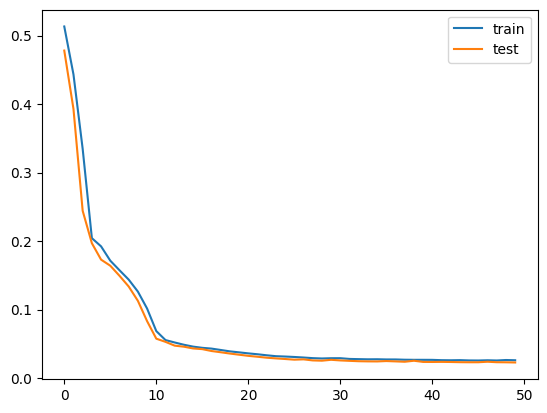

In [355]:
model = Sequential()
model.add(LSTM(50, return_sequences=True
               ,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=128, 
                    validation_data=(X_test, y_test),
                    verbose=0)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Evaluate Model

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.


With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.


In [356]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

24/24 [==============================] - 0s 660us/step


In [357]:
X_test.shape

(740, 7)

In [348]:
X_test[0]

array([0.46323968, 0.84946237, 0.8257277 , 0.35136642, 0.67644707,
       0.72165322, 0.7247696 ])

In [360]:
X_test[:, :].shape

(740, 7)

In [358]:
# invert scaling for forecast
test_out = np.concatenate((X_test[:, :-1], yhat), axis=1)
test_out = scaler.inverse_transform(test_out)
test_out.shape

ValueError: operands could not be broadcast together with shapes (740,8) (7,) (740,8) 

In [305]:
inv_yhat = inv_yhat[:,0]


(740, 7)

In [291]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 145.590


In [ ]:
np.concatenate()